In [1]:
from pathlib import Path
from datetime import datetime
import json
import simplejson

# EXPERIMENT_FOLDER = f'./experiments/vary_pm/{datetime.now().strftime("%d-%m_%H-%M")}'
# EXPERIMENT_FOLDER = "./experiments/vary_pm/25-09_13-13"
EXPERIMENT_FOLDER = "./experiments/vary_pm/24-09_09-40"

In [2]:
EXPERIMENT_FOLDER

'./experiments/vary_pm/24-09_09-40'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_defaults()
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [4]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [5]:
NUM_CLASSES = 3
BATCH_SIZE = 32
CHANNEL_SIZE = 5
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [6]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

# Run Experiments

In [7]:
def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class
    )

def create_self_play_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 
        'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

def create_unkind_mutation_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate, 
        'kind_mutations': False,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

In [8]:
from itertools import combinations

def test_game(teacher, student, num_tests=5):
    games_played = []
    for _ in range(num_tests):
        inputs, targets = generate_test_batch()
        outputs = play_game(
            inputs, teacher, student, 
            training=False, 
            channel_size=CHANNEL_SIZE,
            p_mutate=0,
        )
        games_played.append((inputs, targets, outputs))
    return games_played

In [9]:
class MetaExperiment:
    
    def __init__(
        self,
        num_experiments=3,
        create_experiment_fn=create_self_play_experiment,
        print_prehistory=None,
        name='meta_experiment',
        **make_experiment_kwargs
    ):
        self.num_experiments = num_experiments
        self.results = None
        self.print_prehistory = print_prehistory or (lambda: None)
        self.name = name
        self.experiments = [
            {
                'experiment': create_experiment_fn(
                    print_prehistory=self.print_history,
                    **make_experiment_kwargs
                ),
                'status': 'Not Run',
                'results': None,
                'index': i,
            }
            for i in range(num_experiments)
        ]
    
    def print_history(self):
        self.print_prehistory()
        print(f'Running {self.name}...')
        num_complete = len([
            item for item in self.experiments
            if item['status'] == 'Complete'
        ])
        for item in self.experiments:
            if item['status'] == 'Complete':
                item['experiment'].print_results()
        for item in self.experiments:
            if item['status'] == 'In Progress':
                print(f"Running experiment {item['index']}", 
                      f'({num_complete}/{self.num_experiments} complete):')
                break
                
    def print_results(self):
        print(self.name, 'results: ', self.results)

    def is_finished(self):
        return all([
            item['status'] == 'Complete' 
            for item in self.experiments
        ])
    
    def get_experiment_to_run(self):
        for item in self.experiments:
            if item['status'] == 'In Progress':
                return item
        not_run = [
            item
            for item in self.experiments
            if item['status'] == 'Not Run'
        ]
        if len(not_run) == 0:
            return None
        return not_run[0]
    
    def get_experiment_results(self, experiment):
        test_metrics_items = [
            item['test_metrics']
            for item in experiment.training_history
            if 'test_metrics' in item
        ]
        return test_metrics_items[-1]
    
    def _run_next_subexperiment(self):
        experiment_item = self.get_experiment_to_run()
        index = experiment_item['index']
        experiment = experiment_item['experiment']

        self.experiments[index]['status'] = 'In Progress'

        experiment.run(catch_interrupt=False)

        self.experiments[index]['results'] = \
            self.get_experiment_results(experiment)
        self.experiments[index]['status'] = 'Complete'
        
    def _get_results(self):
        return self.measure_zero_shot_coordination()
    
    def _run_internal(self):
        while not self.is_finished():
            self._run_next_subexperiment()
        
        self.results = self._get_results()
            
    def measure_zero_shot_coordination(self):
        results = []

        for item_1, item_2 in combinations(self.experiments, 2):
            e1 = item_1['experiment']
            e2 = item_2['experiment']

            games_played = test_game(e1.teacher, e2.student)
            test_metrics = e1.extract_test_metrics(games_played)
            results.append(test_metrics['mean_ground_truth_f1'])

            games_played = test_game(e2.teacher, e1.student)
            test_metrics = e1.extract_test_metrics(games_played)
            results.append(test_metrics['mean_ground_truth_f1'])

        return results
    
    def run(self, catch_interrupt=True):
        if catch_interrupt:
            try:
                self._run_internal()
            except KeyboardInterrupt:
                pass
            self._run_internal()
        else:
            self._run_internal()
        
        clear_output()
        self.print_history()
        print('Run Stopped.')

## Investigating the effect of message mutation:

In [44]:
class VaryPMutateExperiment(MetaExperiment):
    
    def __init__(self, 
                 num_intervals=5, 
                 save_location=None, 
                 **experiment_kwargs):
        self.num_experiments = num_intervals
        self.name = 'vary_pm_experiment'
        self.experiments = [
            {
                'p_mutate': i/num_intervals,
                'experiment': MetaExperiment(
                    p_mutate=i/num_intervals, 
                    print_prehistory=self.print_history,
                    name=f'meta_experiment_pm={i/num_intervals}',
                    **experiment_kwargs
                ),
                'status': 'Not Run',
                'results': None,
                'index': i,
            }
            for i in range(num_intervals+1)
        ]
        
        self.save_location = save_location
        if save_location is not None:
            self.load_history(save_location)
    
    def get_experiment_results(self, meta_experiment):
        return meta_experiment.results
    
    def _run_next_subexperiment(self):
        super(VaryPMutateExperiment, self)._run_next_subexperiment()
        self.export_data()
        clear_output()
        self.print_history()
        
    def _get_results(self):
        return None
    
    def print_prehistory(self):
        pass
            
    def load_history(self, history_location):
        experiment_path = Path(history_location)
        for path in experiment_path.glob('*'):
            metadata = json.load((path / 'meta.json').open(mode='r'))
            results = json.load((path / 'results.json').open(mode='r'))
            i = metadata['index']
            self.experiments[i]['status'] = 'Complete'
            self.experiments[i]['results'] = results['zs_coord_f1_scores']
            meta_exp = self.experiments[i]['experiment']
            meta_exp.results = results['zs_coord_f1_scores']
            
            for item in meta_exp.experiments:
                history_path = path / f"experiment_{item['index']}_logs.json"
                training_history = json.load(history_path.open(mode='r'))
                item['experiment'].training_history = training_history
    
    def export_data(self):
        Path(self.save_location).mkdir(exist_ok=True)
        for item_1 in self.experiments:
            if item_1['status'] == 'Complete':
                try:
                    meta_exp = item_1['experiment']
                    meta_exp_subfolder = \
                        f'{self.save_location}/pm={item_1["p_mutate"]}'
                    Path(meta_exp_subfolder).mkdir()

                    experiment_config = \
                        meta_exp.experiments[0]['experiment'].get_config()
                    meta_data = {
                        'index': item_1['index'], 
                        'p_mutate': item_1['p_mutate'],
                        'experiment_config': experiment_config
                    }
                    meta_data_path = Path(f'{meta_exp_subfolder}/meta.json')
                    with meta_data_path.open(mode='w') as f:
                        json.dump(meta_data, f)

                    results = {
                        'zs_coord_f1_scores': item_1['results']
                    }
                    results_path = Path(f'{meta_exp_subfolder}/results.json')
                    with results_path.open(mode='w') as f:
                        simplejson.dump(results, f)

                    for item_2 in meta_exp.experiments:
                        logs_file_loc = \
                            f"{meta_exp_subfolder}/experiment_{item_2['index']}_logs.json"
                        logs_file_path = Path(logs_file_loc)

                        with logs_file_path.open(mode='w') as f:
                            json.dump(item_2['experiment'].training_history, f)

                    print('Saved experiment data at:', meta_exp_subfolder)
                except FileExistsError:
                    print('Experiment', item_1['index'], 'already saved.')

In [45]:
vary_pm_experiment = VaryPMutateExperiment(save_location=EXPERIMENT_FOLDER,
                                           create_experiment_fn=create_unkind_mutation_experiment)

In [46]:
vary_pm_experiment.run()

Running vary_pm_experiment...
meta_experiment_pm=0.0 results:  [0.34375, 0.41875, 0.36250000000000004, 0.6, 0.2625, 0.26875]
meta_experiment_pm=0.2 results:  [0.85, 0.85625, 0.91875, 0.81875, 0.69375, 0.6625]
meta_experiment_pm=0.4 results:  [0.9125, 1.0, 1.0, 1.0, 1.0, 1.0]
meta_experiment_pm=0.6 results:  [0.7875, 0.79375, 0.85, 0.6625, 0.68125, 0.68125]
meta_experiment_pm=0.8 results:  [0.71875, 0.6875, 0.66875, 0.68125, 0.6375, 0.66875]
meta_experiment_pm=1.0 results:  [0.48125000000000007, 0.48125000000000007, 0.44375, 0.5125, 0.5125, 0.49375]
Run Stopped.


In [48]:
df = pd.DataFrame([
    {
        'Mutation Probability': item['p_mutate'],
        'Zero-Shot Coordination Score': score,
    }
    for item in vary_pm_experiment.experiments
    if item['status'] == 'Complete'
    for score in item['results']
])

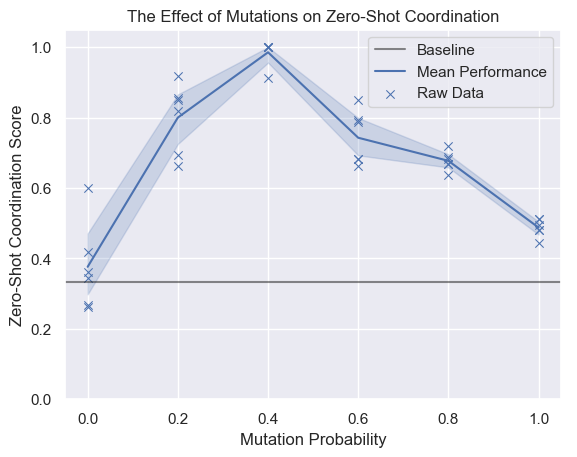

In [49]:
sns.lineplot(x=[-2, 2], y=[1/NUM_CLASSES, 1/NUM_CLASSES], dashes=True, color=(0.1, 0.1, 0.1, 0.5), label='Baseline')
sns.lineplot(x='Mutation Probability', y='Zero-Shot Coordination Score', data=df, label='Mean Performance')
sns.scatterplot(x='Mutation Probability', y='Zero-Shot Coordination Score', data=df, marker='x', label='Raw Data')
plt.ylim([0, 1.05])
plt.xlim([-.05, 1.05])
plt.title('The Effect of Mutations on Zero-Shot Coordination')
plt.show()

In [50]:
df_train = pd.DataFrame([
    {
        'Epoch': epoch,
        'Experiment': f"p_m={item_1['p_mutate']}",
        'Train Loss': training_item['loss']
    }
    for item_1 in vary_pm_experiment.experiments
    for item_2 in item_1['experiment'].experiments
    for epoch, training_item in enumerate(item_2['experiment'].training_history) 
])

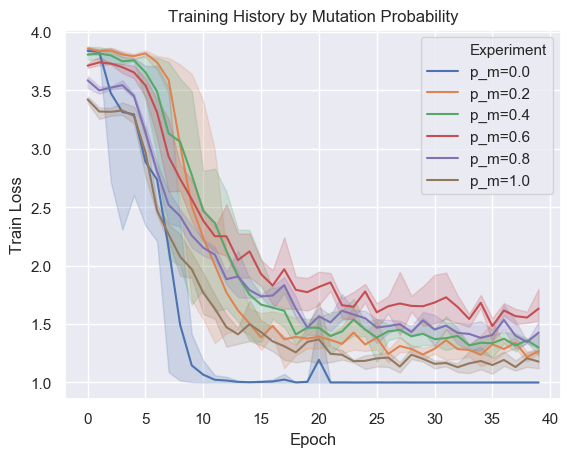

In [51]:
sns.lineplot(x='Epoch', y='Train Loss', hue='Experiment', data=df_train);
# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training History by Mutation Probability')
plt.show()

In [52]:
df_test = pd.DataFrame([
    {
        'Epoch': epoch,
        'Experiment': f"p_m={item_1['p_mutate']}",
        'F1-Score': training_item['test_metrics']['mean_ground_truth_f1']
    }
    for item_1 in vary_pm_experiment.experiments
    for item_2 in item_1['experiment'].experiments
    for epoch, training_item in enumerate(item_2['experiment'].training_history)
    if 'test_metrics' in training_item
])

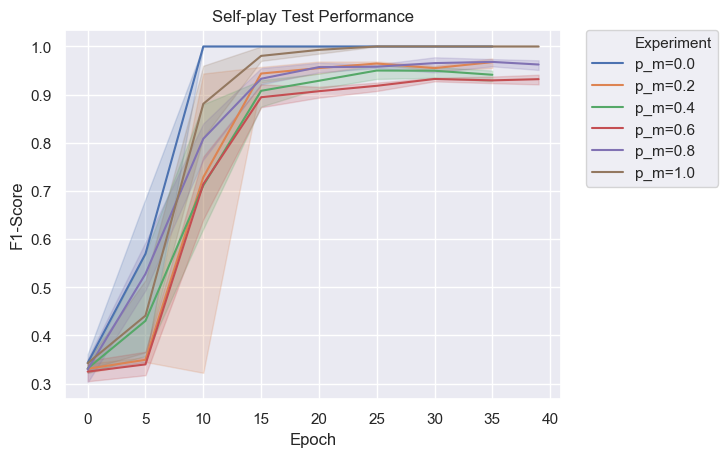

In [53]:
sns.lineplot(x='Epoch', y='F1-Score', hue='Experiment', data=df_test);
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Self-play Test Performance')
plt.show()

## Investigating the effects of message permutation:

In [12]:
def create_message_permutation_experiment(channel_size=5, **exp_kwargs):
    
    agent = Agent(channel_size, NUM_CLASSES)

    play_params =  {
        'channel_size': channel_size,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )


def create_message_permutation_is_all_you_need_experiment(channel_size=5, epochs=300, **exp_kwargs):
    
    agent = Agent(channel_size, NUM_CLASSES)

    play_params =  {
        'channel_size': channel_size,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=0.1,
        **exp_kwargs
    )

In [14]:
permutation_experiment = MetaExperiment(
    create_experiment_fn=create_message_permutation_is_all_you_need_experiment,
    num_experiments=6
)

In [15]:
permutation_experiment.run()

Running meta_experiment...
Test Loss: 0.456, Ground Truth F1-Score: 0.661, Student Error: 2.251, Teacher Error: 9.554, Protocol Diversity: 0.5,
Test Loss: 0.465, Ground Truth F1-Score: 0.671, Student Error: 1.815, Teacher Error: 9.8, Protocol Diversity: 0.5,
Test Loss: 0.449, Ground Truth F1-Score: 0.675, Student Error: 1.252, Teacher Error: 6.87, Protocol Diversity: 0.799,
Running experiment 3 (3/6 complete):
Running experiment...
Run config:
 {'name': 'experiment', 'max_epochs': 300, 'steps_per_epoch': 50, 'epochs_optimised': 237, 'loss_fn': 'student_pred_matches_test_class', 'play_params': {'channel_size': 5, 'p_mutate': 0, 'message_permutation': True}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}}
Epoch 0, Time Taken (mm:ss): 0:26, Mean Loss: 1.106
Test Loss: 1.107, Ground Truth F1-Score: 0.341, Student Error: 1.106, Teac

Epoch 99, Time Taken (mm:ss): 0:36, Mean Loss: 0.532
Epoch 100, Time Taken (mm:ss): 0:40, Mean Loss: 0.414
Test Loss: 0.451, Ground Truth F1-Score: 0.67, Student Error: 1.199, Teacher Error: 9.668, Protocol Diversity: 0.5,


KeyboardInterrupt: 

In [17]:
permutation_experiment.experiments

[{'experiment': <zscomm.experiment.Experiment at 0x203af3bb860>,
  'status': 'Complete',
  'results': {'mean_test_loss': 0.45613521337509155,
   'mean_ground_truth_f1': 0.66125,
   'mean_student_error': 2.2511374950408936,
   'mean_teacher_error': 9.554040908813477,
   'mean_protocol_diversity': 0.5},
  'index': 0},
 {'experiment': <zscomm.experiment.Experiment at 0x203af38c908>,
  'status': 'Complete',
  'results': {'mean_test_loss': 0.46481552720069885,
   'mean_ground_truth_f1': 0.67125,
   'mean_student_error': 1.8147448301315308,
   'mean_teacher_error': 9.799999237060547,
   'mean_protocol_diversity': 0.5},
  'index': 1},
 {'experiment': <zscomm.experiment.Experiment at 0x203af39ca20>,
  'status': 'Complete',
  'results': {'mean_test_loss': 0.44938552379608154,
   'mean_ground_truth_f1': 0.675,
   'mean_student_error': 1.252317190170288,
   'mean_teacher_error': 6.870226860046387,
   'mean_protocol_diversity': 0.7987499833106995},
  'index': 2},
 {'experiment': <zscomm.experiment

In [16]:
permutation_experiment.results

In [ ]:
for item in permutation_experiment.experiments:
    logs_file_loc = \
        f"experiments/permutation_is_all_you_need/experiment_{item['index']}_logs.json"
    logs_file_path = Path(logs_file_loc)

    with logs_file_path.open(mode='w') as f:
        json.dump(item_2['experiment'].training_history, f)

In [18]:
for item in permutation_experiment.experiments:
    if item['status'] == 'Complete':
        total_time = sum([
            x['seconds_taken']
            for x in item['experiment'].training_history
        ])
        print(total_time)

5024.316277265549
7245.545756340027
8573.50793838501


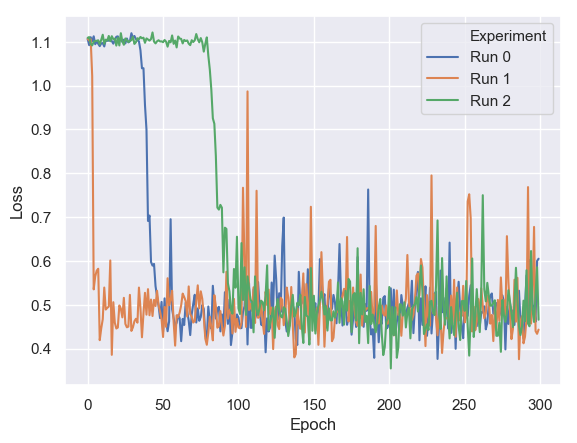

In [57]:
df = pd.DataFrame([
    {
        'Epoch': epoch,
        'Loss': train_item['loss'],
        'Experiment': f"Run {item['index']}",
    }
    for item in permutation_experiment.experiments
    if item['status'] == 'Complete'
    for epoch, train_item in enumerate(item['experiment'].training_history)
])

sns.lineplot(x='Epoch', y='Loss', hue='Experiment', data=df);

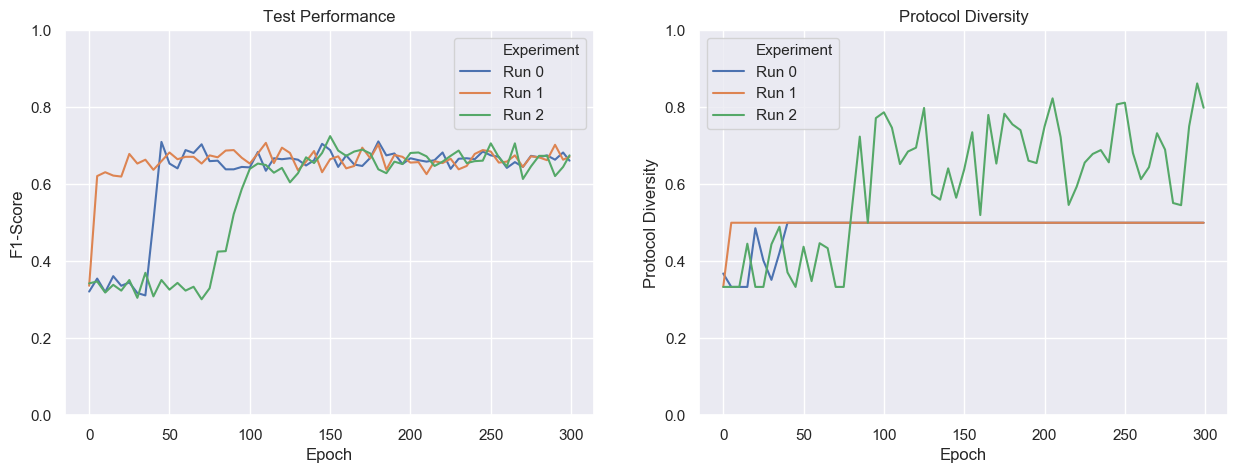

In [58]:
df = pd.DataFrame([
    {
        'Epoch': epoch,
        'F1-Score': train_item['test_metrics']['mean_ground_truth_f1'],
        'Protocol Diversity': train_item['test_metrics']['mean_protocol_diversity'],
        'Experiment': f"Run {item['index']}",
    }
    for item in permutation_experiment.experiments
    if item['status'] == 'Complete'
    for epoch, train_item in enumerate(item['experiment'].training_history)
    if 'test_metrics' in train_item
])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title('Test Performance')
axs[1].set_title('Protocol Diversity')

sns.lineplot(x='Epoch', y='F1-Score', hue='Experiment', data=df, ax=axs[0]);
sns.lineplot(x='Epoch', y='Protocol Diversity', hue='Experiment', data=df, ax=axs[1]);
for ax in axs:
    ax.set_ylim([0, 1])

In [65]:
games_played, _ = permutation_experiment.experiments[1]['experiment'].run_tests()

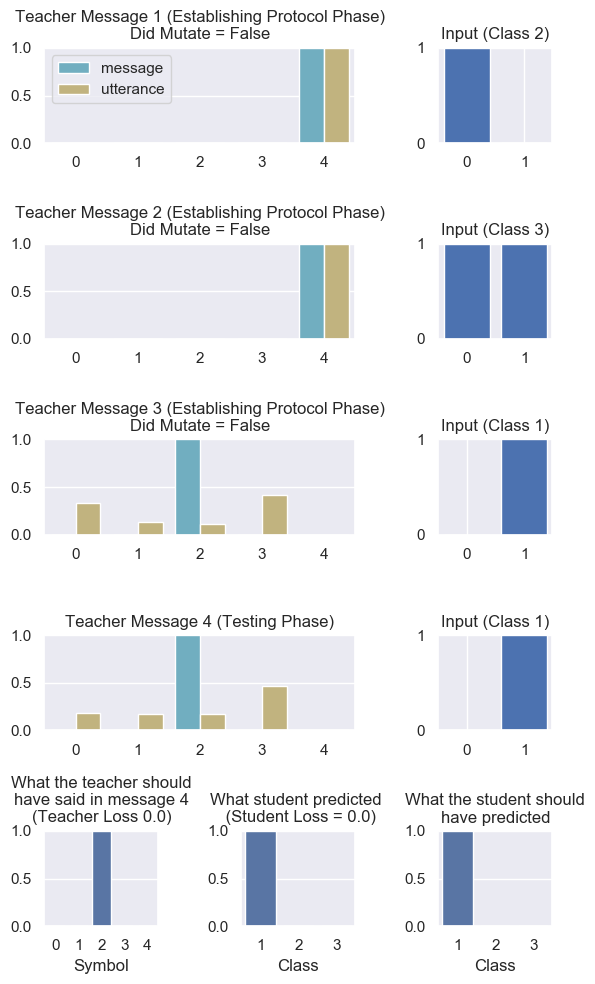

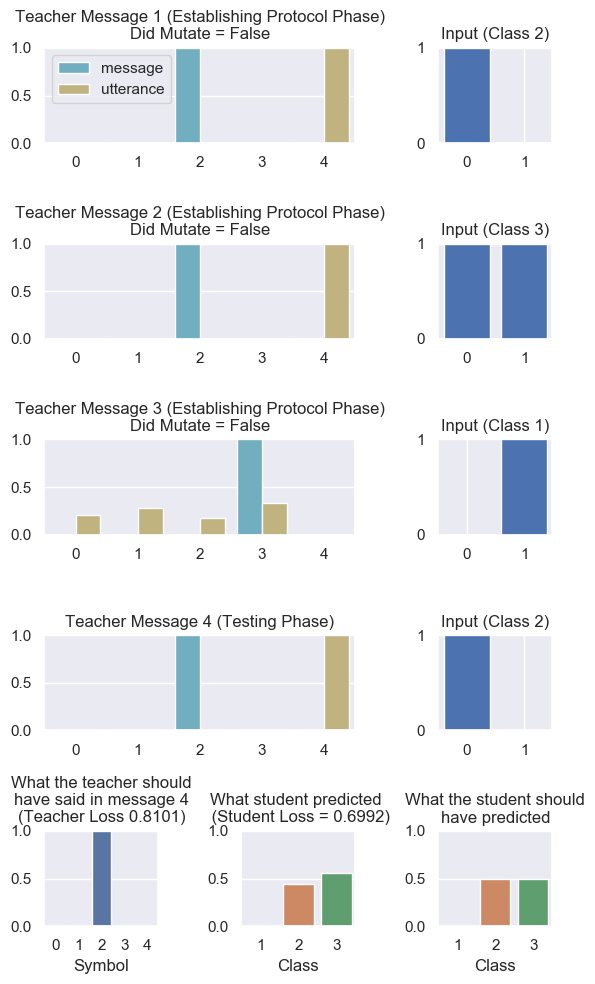

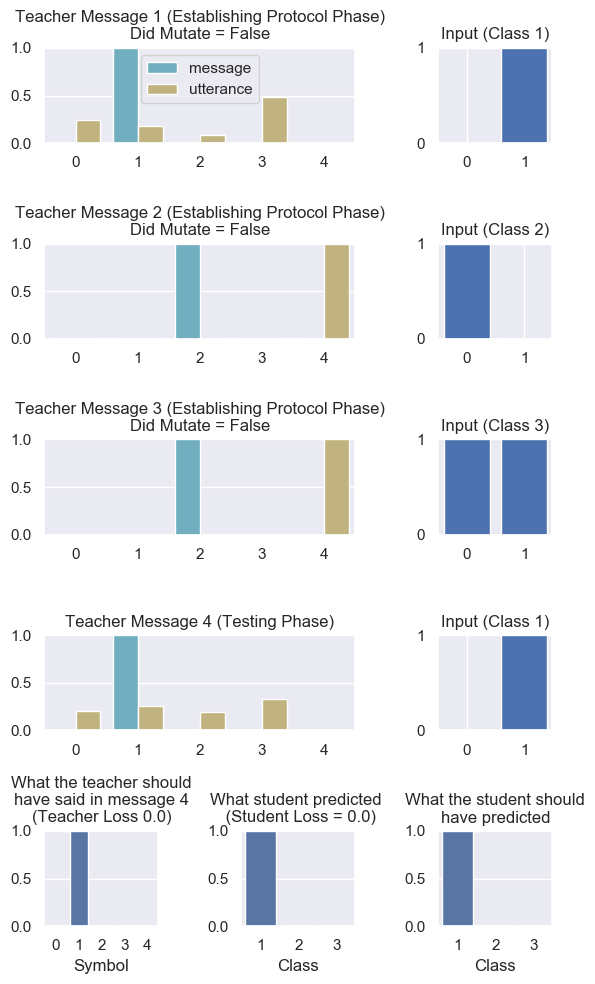

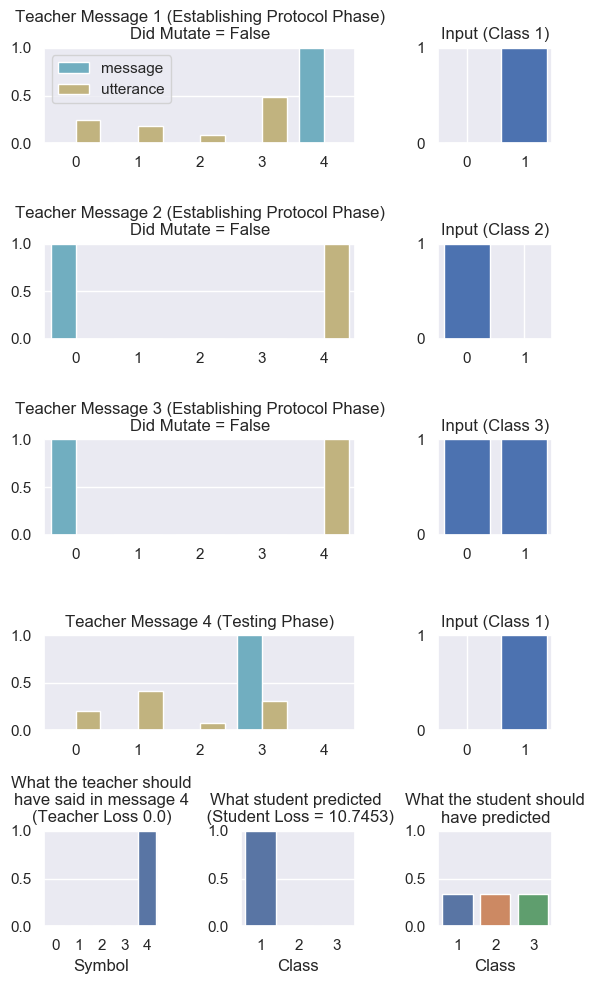

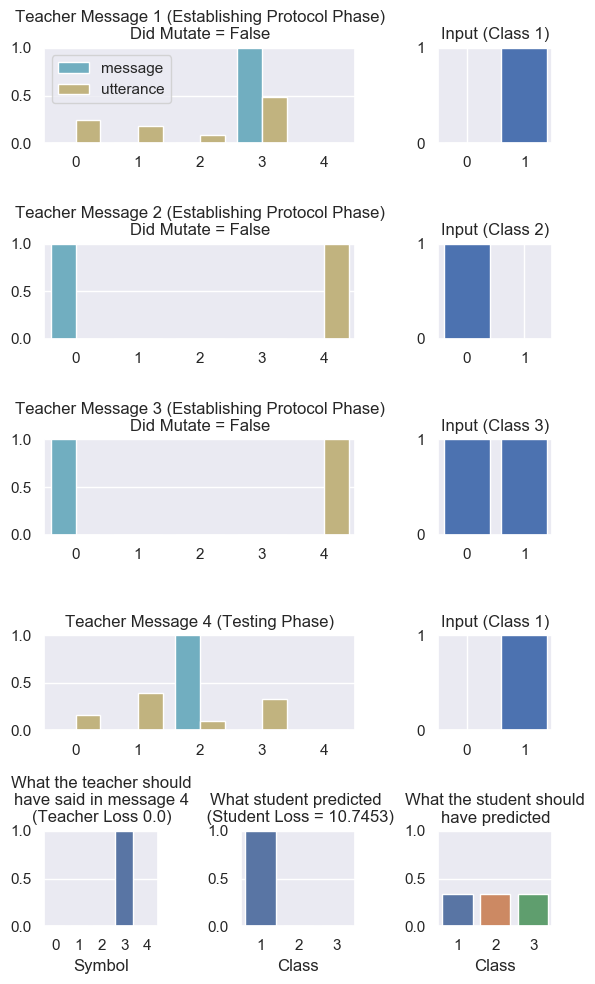

In [66]:
for i in range(5):
    inputs, targets, outputs = games_played[i]
    plot_game(inputs, outputs, targets, select_batch=0)

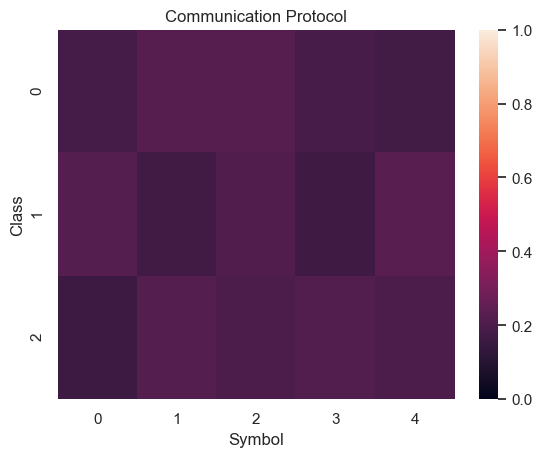

In [67]:
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

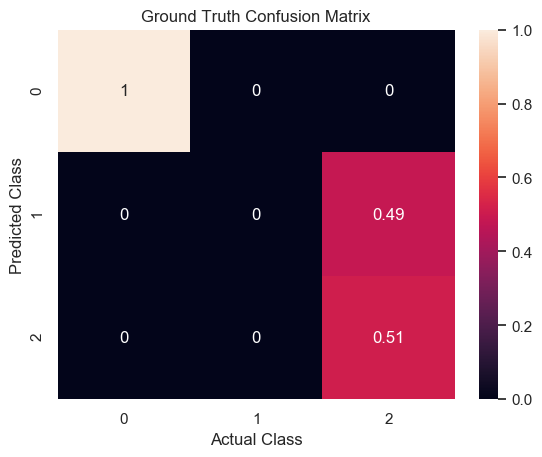

In [68]:
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

In [64]:
teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)
student = Agent(CHANNEL_SIZE, NUM_CLASSES)

inputs, targets = generate_train_batch()

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student, 
                        training=True, 
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0,
                        message_permutation=True)

    loss = student_pred_matches_test_class(outputs, targets)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)
student_grads = tape.gradient(loss, student.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

print()

for v, g in zip(student.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense_50/kernel:0 teacher grad norm: 0.15135417878627777
agent/dense_50/bias:0 teacher grad norm: 0.13103458285331726
agent/lstm_25/kernel:0 teacher grad norm: 0.27743422985076904
agent/lstm_25/recurrent_kernel:0 teacher grad norm: 0.044859629124403
agent/lstm_25/bias:0 teacher grad norm: 0.12432169169187546
agent/dense_51/kernel:0 teacher grad norm: 0.1113242655992508
agent/dense_51/bias:0 teacher grad norm: 0.12321121990680695

agent/dense_52/kernel:0 student grad norm: 4.158194541931152
agent/dense_52/bias:0 student grad norm: 4.717851161956787
agent/lstm_26/kernel:0 student grad norm: 6.425166130065918
agent/lstm_26/recurrent_kernel:0 student grad norm: 1.862521767616272
agent/lstm_26/bias:0 student grad norm: 4.953880310058594
agent/dense_53/kernel:0 student grad norm: 2.9622983932495117
agent/dense_53/bias:0 student grad norm: 5.182008743286133
